In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import datetime
import requests
import json
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
pd.set_option('display.max_rows',100)

In [3]:
def createDayDataframe(filename):
    path = "tongsdata/"
    filedate = filename.split(".")[0].split("-")

    with open(path + filename, 'r', encoding='utf-8') as fin:
        data_json = json.loads(fin.read())

    #  Create X DataFrame
    todayData = {time: data_json[time]['currently'] for time in data_json}
    todayData_DF = pd.DataFrame(todayData).T

    #  Create y DataFrame
    energyBalanceFilename = "energyBalance/Energy_Balance_{}_{}_{}.csv".format(filedate[0], filedate[1], filedate[2]) #change due to json filename
    energyBalance = pd.read_csv(path + energyBalanceFilename, delimiter=";")

    energyBalance_DF = pd.DataFrame(index=energyBalance.iloc[:-1,0].apply(lambda x: x[2:-1]))
    energyBalance_DF['PV Power Generation'] = energyBalance['PV power generation / Mean values [W]  '].values[:-1]
    energyBalance_DF = energyBalance_DF[energyBalance_DF != ' ']
    energyBalance_DF = energyBalance_DF.dropna()

    #  Join X y DataFrame
    data = todayData_DF.join(energyBalance_DF)
    return data

def cleanDataframe(masterDF):
    masterData_cleaned = masterDF.reset_index()
    masterData_cleaned = masterData_cleaned.rename(columns={'index': 'time_of_day'})
    masterData_cleaned = masterData_cleaned[masterData_cleaned['PV Power Generation'].notna()]
    #masterData_cleaned['month'] = masterData_cleaned['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
    masterData_cleaned['cloudCover'] = masterData_cleaned['cloudCover'].fillna(value=masterData_cleaned['cloudCover'].mean())
    masterData_cleaned['PV Power Generation'] = masterData_cleaned['PV Power Generation'].apply(lambda x: x.replace(",", "")).astype('float')
    return masterData_cleaned

def featureEngineering(masterDF):
    masterDF = masterDF.drop(columns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure','precipType'])
    #masterDF = pd.get_dummies(masterDF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])
    masterDF = pd.get_dummies(masterDF, columns=['time_of_day'])
    return masterDF

    

### รันแค่ครั้งเดียวเพื่อ fit model

In [4]:
import os
import pandas as pd
import json
import datetime

files = os.listdir("tongsdata/")

#files.remove(".DS_Store")
files.remove("energyBalance")

masterData = pd.DataFrame()

for file in files:
    r = createDayDataframe(file).loc['06:30':'18:00']
    #print(file, r.shape)
    masterData = pd.concat([masterData, r], axis=0)

masterData = cleanDataframe(masterData)
masterData = featureEngineering(masterData)

features = list(masterData.drop(columns=['PV Power Generation']).columns)

masterData = masterData.dropna()

X = masterData.drop(columns=['PV Power Generation']).astype('float').values
y = masterData['PV Power Generation'].astype('float').values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

training_features, testing_features, training_target, testing_target = train_test_split(X, y)

# Average CV score on the training set was:-91867.4890210794
exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=1, min_samples_split=7, n_estimators=100)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

#from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
#print(mean_squared_error(testing_target, results), 
#mean_absolute_error(testing_target, results), 
#r2_score(testing_target, results))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [5]:
def clean1(date):
    date = date.split("-")
    path = "tongsdata/"
    filename = "energyBalance/Energy_Balance_{}_{}_{}.csv".format(date[0], date[1], date[2])
    rawdata=pd.read_csv(path + filename, delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=date[0]+date[1]+date[2]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    return rawdata

In [6]:
def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    EPSILON = 1e-10
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))*100

Start to test here

In [7]:
date = "2018-11-23"
df = clean1(date)

In [8]:
def predictgen(predict_date):
    path = "tongsdata/"
    filename = predict_date.replace("_",'-') + '.json'
    
    with open(path + filename, 'r', encoding='utf-8') as fin:
        data_json = json.loads(fin.read())
    
    todayData = {time: data_json[time]['currently'] for time in data_json}
    todayData_DF = pd.DataFrame(todayData).T
    
    todayData_DF.index.names=['time_of_day']
    todayData_DF = todayData_DF.loc['06:30':'18:00']
    todayData_DF = todayData_DF.reset_index()
    #todayData_DF['month'] = todayData_DF['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
    
    todayData_DF['cloudCover'] = todayData_DF['cloudCover'].fillna(value=todayData_DF['cloudCover'].mean())
    #todayData_DF['cloudCover'] = 0.19
    dropcolumns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure','precipType']
    for i in dropcolumns:
        if i in todayData_DF.columns:
            todayData_DF = todayData_DF.drop(columns=[i])
    #todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])
    todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day'])

    masterData_for_predict = masterData.drop(columns=['PV Power Generation'])
    for i in range(len(masterData_for_predict.columns)) : #drop power balance
        if masterData_for_predict.columns[i] not in todayData_DF.columns:
            todayData_DF.insert(i, masterData.columns[i+1], 0)
    missingvalue = todayData_DF[todayData_DF.isna().any(axis=1)].index
    
    col = ['apparentTemperature','cloudCover','dewPoint','humidity','temperature','visibility','windSpeed']
    for col in todayData_DF:
        todayData_DF[col] = pd.to_numeric(todayData_DF[col], errors='coerce')
    if todayData_DF.isna().loc[0,'uvIndex']:
        todayData_DF.loc[0,'uvIndex'] = 0
    todayData_DF=todayData_DF.interpolate(limit_direction='both')
    
    first_predict = todayData_DF.astype('float').values
    
    results_first_predict = exported_pipeline.predict(first_predict)
    results_first_predict = np.array(results_first_predict).tolist()
    for i in range(25):
        results_first_predict.insert(0,0.0)
    for j in range (24):
        results_first_predict.append(0.0)
    return results_first_predict

In [9]:
df["Forecasted Generation"] = predictgen(date)

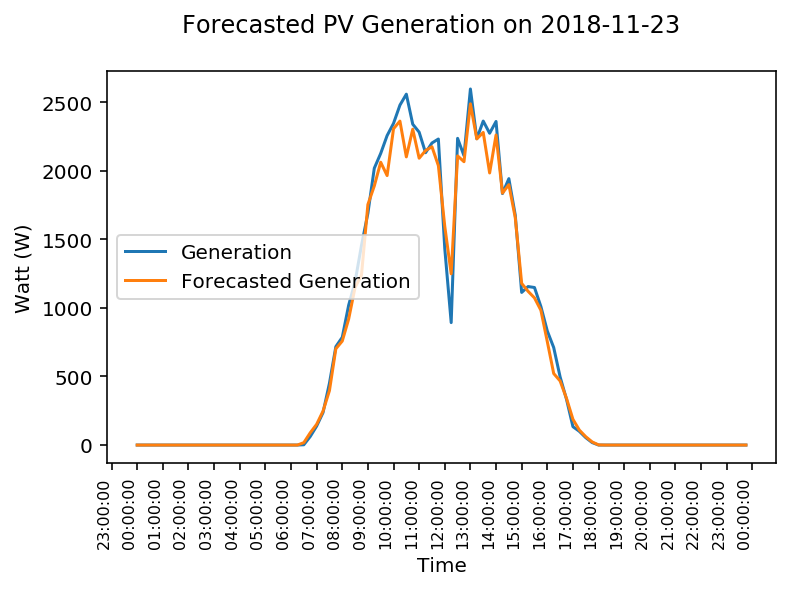

In [10]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')


df[['Generation' ,'Forecasted Generation']].plot(ax = ax, x_compat=True)
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.xticks(rotation='vertical', fontsize = 8)
plt.ylabel('Watt (W)')
plt.suptitle('Forecasted PV Generation on ' + date)
plt.show()

In [13]:
df1 = df[['Generation','Forecasted Generation']]
df1 = df1.rename(columns={'Generation': 'Real Generation'})
df1["AAPE"] = 0

for index, row in df1.iterrows():
    error = maape(row["Real Generation"], row["Forecasted Generation"])
    df1.loc[index,'AAPE'] = error

In [19]:
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
for index, row in df1.iterrows():
    r2 = r2_score(row["Real Generation"], row["Forecasted Generation"])
    df1.loc[index,'R2score'] = r2

TypeError: Singleton array 0.0 cannot be considered a valid collection.

In [17]:
df1

,Real Generation,Forecasted Generation,AAPE,R2score
Time,,,,
2018-11-23 00:15:00,0,0.000000,0.000000,0.989804
2018-11-23 00:30:00,0,0.000000,0.000000,0.989804
2018-11-23 00:45:00,0,0.000000,0.000000,0.989804
2018-11-23 01:00:00,0,0.000000,0.000000,0.989804
2018-11-23 01:15:00,0,0.000000,0.000000,0.989804
2018-11-23 01:30:00,0,0.000000,0.000000,0.989804
2018-11-23 01:45:00,0,0.000000,0.000000,0.989804
2018-11-23 02:00:00,0,0.000000,0.000000,0.989804
2018-11-23 02:15:00,0,0.000000,0.000000,0.989804


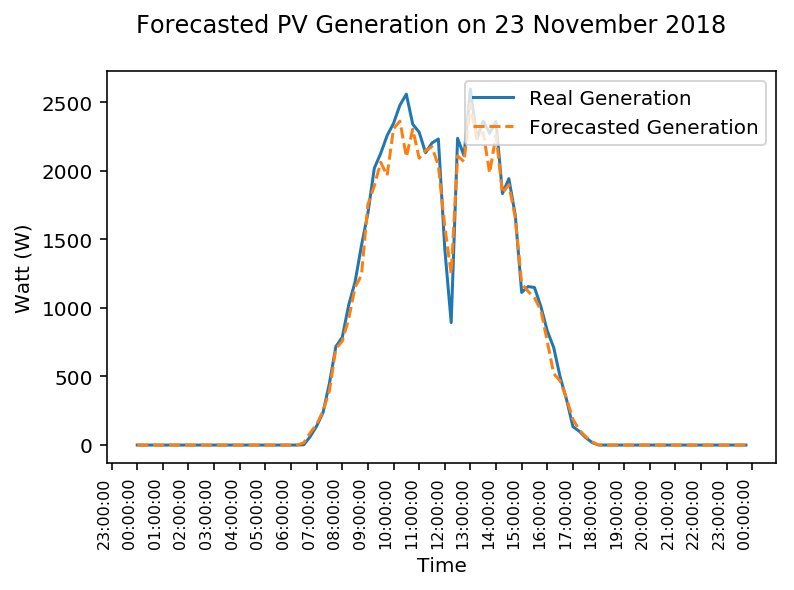

In [12]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')


df1['Real Generation'].plot(ax = ax, x_compat=True)
df1['Forecasted Generation'].plot(ax = ax, x_compat=True, linestyle='--')
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.xticks(rotation='vertical', fontsize = 8)
plt.ylabel('Watt (W)')
plt.suptitle('Forecasted PV Generation on 23 November 2018')
legend = ax.legend(loc='upper right')
#plt.savefig('FPV_09Nov.png')
plt.show()

In [568]:
each_day_error = df1.loc[date +' 06:30:00':date +' 18:00:00','AAPE'].mean()

#df5 = pd.DataFrame()
df5 = df5.append({"Date": date, "MAAPE": each_day_error}, ignore_index=True)
df5

,Date,MAAPE
0,2018-11-01,28.867601
1,2018-11-03,28.271282


In [561]:
df2

,MAAPE
Date,
2018-11-01,28.867601
2018-11-03,28.271282
2018-11-04,18.667655
2018-11-05,12.769683
2018-11-06,29.178154
2018-11-07,20.070027
2018-11-08,20.912153
2018-11-09,42.419775
2018-11-10,20.866775


In [506]:
df2.to_csv('MAAPE_Nov.csv')

In [542]:
df2.max()

MAAPE    42.419775
dtype: float64

In [430]:
df2["Date"] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')
df2.set_index('Date', inplace=True)
df2

,level_0,index,MAAPE
Date,,,
2018-11-01,0,0,28.867601
2018-11-03,1,1,28.271282
2018-11-04,2,2,18.667655
2018-11-05,3,3,12.769683
2018-11-06,4,4,29.178154
2018-11-07,5,5,20.070027
2018-11-08,6,6,20.912153
2018-11-09,7,7,42.419775
2018-11-10,8,8,20.866775


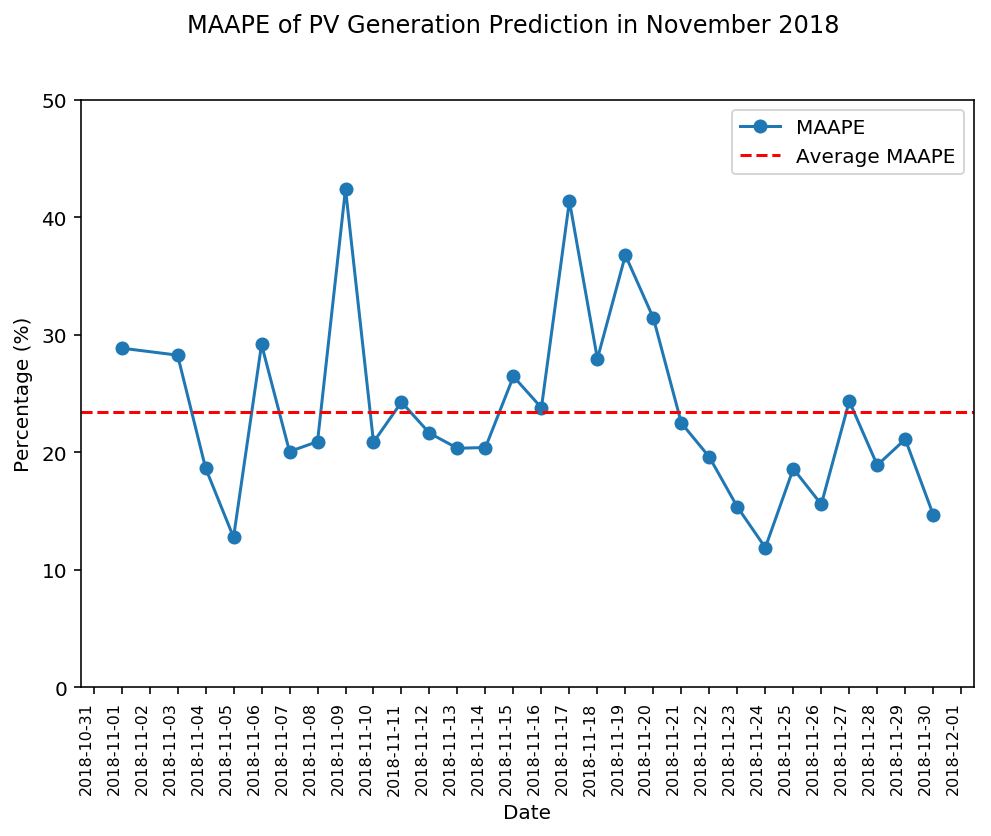

In [497]:
fig, ax = plt.subplots()

day = mdates.DayLocator(interval = 1)
myFmt = mdates.DateFormatter('%Y-%m-%d')

df2["MAAPE"].plot(ax = ax, x_compat=True ,marker='o')
#Then tick and format with matplotlib:
y_mean = df2["MAAPE"].mean()
plt.axhline(y=y_mean, label='Average MAAPE', linestyle='--', color='red')

ax.xaxis.set_major_locator(day)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.xticks(rotation='vertical', fontsize = 8)
ax.set_ylim(ymin=0, ymax=50)
legend = ax.legend(loc='upper right')
plt.ylabel('Percentage (%)')
plt.suptitle('MAAPE of PV Generation Prediction in November 2018')


# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.savefig('MAAPE_Nov.png')
#plt.show()

In [489]:
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)

Current size: [6.0, 4.0]


In [503]:
df2["MAAPE"].mean()
df2["MAAPE"].std()

7.620925420247845

วันที่ 3 ผิดเยอะเนื่องจาก uvIndex ที่เรียกมาเป็นNaNเยอะ

วันที่ 4 ผิดช่วงที่ uvIndex เป็น NaN

1,2,3,4,6,9,10,17,19,25

Text(0, 0.5, 'Watt (W)')

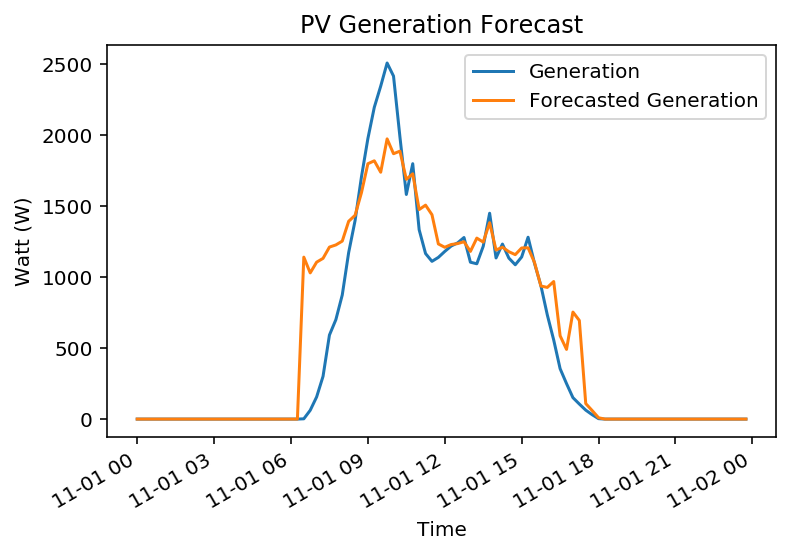

In [31]:
df[['Generation' ,'Forecasted Generation']].plot(kind='line', title='PV Generation Forecast').set_ylabel('Watt (W)')

In [218]:
predict_date = '2018-11-09'
path = "tongsdata/"
filename = predict_date.replace("_",'-') + '.json'

with open(path + filename, 'r', encoding='utf-8') as fin:
    data_json = json.loads(fin.read())

todayData = {time: data_json[time]['currently'] for time in data_json}
todayData_DF = pd.DataFrame(todayData).T

todayData_DF.index.names=['time_of_day']
todayData_DF = todayData_DF.loc['06:30':'18:00']
todayData_DF = todayData_DF.reset_index()
#todayData_DF['month'] = todayData_DF['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)

todayData_DF['cloudCover'] = todayData_DF['cloudCover'].fillna(value=todayData_DF['cloudCover'].mean())
#todayData_DF['cloudCover'] = 0.19

dropcolumns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure','precipType']
for i in dropcolumns:
    if i in todayData_DF.columns:
        todayData_DF = todayData_DF.drop(columns=[i])
#todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])
todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day'])

masterData_for_predict = masterData.drop(columns=['PV Power Generation'])
for i in range(len(masterData_for_predict.columns)) : #drop power balance
    if masterData_for_predict.columns[i] not in todayData_DF.columns:
        todayData_DF.insert(i, masterData.columns[i+1], 0)
missingvalue = todayData_DF[todayData_DF.isna().any(axis=1)].index

col = ['apparentTemperature','cloudCover','dewPoint','humidity','temperature','visibility','windSpeed']
for col in todayData_DF:
    todayData_DF[col] = pd.to_numeric(todayData_DF[col], errors='coerce')
#todayData_DF=todayData_DF.interpolate(limit_direction='both')

In [219]:
if todayData_DF.isna().loc[0,'uvIndex']:
    todayData_DF.loc[0,'uvIndex'] = 0

In [220]:
todayData_DF=todayData_DF.interpolate(limit_direction='both')

In [221]:
todayData_DF

,apparentTemperature,cloudCover,dewPoint,humidity,temperature,uvIndex,visibility,windSpeed,time_of_day_06:30,time_of_day_06:45,...,time_of_day_15:45,time_of_day_16:00,time_of_day_16:15,time_of_day_16:30,time_of_day_16:45,time_of_day_17:00,time_of_day_17:15,time_of_day_17:30,time_of_day_17:45,time_of_day_18:00
0,86.90,0.45,75.37,0.83,80.93,0,6.22,4.69,1,0,...,0,0,0,0,0,0,0,0,0,0
1,87.00,0.51,74.91,0.82,81.11,0,6.22,5.38,0,1,...,0,0,0,0,0,0,0,0,0,0
2,87.08,0.56,74.44,0.80,81.30,0,6.22,6.18,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87.08,0.56,74.44,0.80,81.30,0,6.22,6.27,0,0,...,0,0,0,0,0,0,0,0,0,0
4,87.08,0.56,74.44,0.80,81.30,1,6.22,6.38,0,0,...,0,0,0,0,0,0,0,0,0,0
5,87.08,0.56,74.44,0.80,81.30,1,6.22,6.50,0,0,...,0,0,0,0,0,0,0,0,0,0
6,87.08,0.56,74.44,0.80,81.30,1,6.22,6.63,0,0,...,0,0,0,0,0,0,0,0,0,0
7,87.56,0.56,74.44,0.79,81.57,2,6.22,6.48,0,0,...,0,0,0,0,0,0,0,0,0,0
8,88.02,0.56,74.44,0.78,81.84,2,6.22,6.35,0,0,...,0,0,0,0,0,0,0,0,0,0
9,88.49,0.56,74.44,0.78,82.12,2,6.22,6.25,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
first_predict = todayData_DF.astype('float').values

results_first_predict = exported_pipeline.predict(first_predict)
results_first_predict = np.array(results_first_predict).tolist()
for i in range(25):
    results_first_predict.insert(0,0.0)
for j in range (24):
    results_first_predict.append(0.0)
results_first_predict

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.365666666666664,
 32.15716666666666,
 68.20366666666668,
 140.04099999999994,
 229.05416666666667,
 240.36050000000003,
 275.2725,
 701.1141666666667,
 509.25683333333336,
 551.2674999999999,
 702.6269999999998,
 759.2963333333333,
 766.8834999999999,
 787.7273333333334,
 1780.6156666666668,
 955.4555000000001,
 775.7796666666665,
 779.6701666666668,
 588.9233333333334,
 546.322,
 562.587,
 520.3351666666667,
 531.0696666666666,
 637.8441666666665,
 876.304666666667,
 587.5236666666667,
 672.2798333333334,
 579.1879999999999,
 625.1938333333333,
 507.52299999999997,
 619.5356666666665,
 611.1146666666665,
 641.1093333333332,
 657.4918333333331,
 578.6138333333332,
 581.5423333333332,
 527.9366666666666,
 396.23800000000006,
 249.2693333333334,
 130.18816666666666,
 119.71516666666666,
 85.73733333333334,
 99.54783333333334,
 84.4028333

In [223]:
from sklearn.feature_selection import SelectFromModel
featuresImportance = pd.DataFrame()
featuresImportance['Feature Name'] = features
featuresImportance['Importance'] = exported_pipeline.feature_importances_

featuresImportance.sort_values('Importance', ascending=False)

,Feature Name,Importance
5,uvIndex,0.517258
4,temperature,0.075463
3,humidity,0.071981
1,cloudCover,0.052690
0,apparentTemperature,0.046353
2,dewPoint,0.039019
7,windSpeed,0.036749
6,visibility,0.028757
53,time_of_day_17:45,0.019669
52,time_of_day_17:30,0.014575


In [536]:
result = pd.DataFrame()
result['Real Generation'] = testing_target
result['Forecasted Generation'] = results
result['MAAPE'] = 0
for index, row in result.iterrows():
    error = maape(row["Real Generation"], row["Forecasted Generation"])
    result.loc[index,'MAAPE'] = error
result

,Real Generation,Forecasted Generation,MAAPE
0,115.0,566.477667,132.138108
1,3.0,4.716500,51.970235
2,405.0,321.094667,20.428370
3,1290.0,1666.397167,28.389924
4,1607.0,1751.908667,8.993019
5,329.0,153.643833,48.969580
6,637.0,596.132667,6.406813
7,2189.0,2129.923333,2.698142
8,19.0,99.547833,133.914615
9,2567.0,2071.565000,19.065732


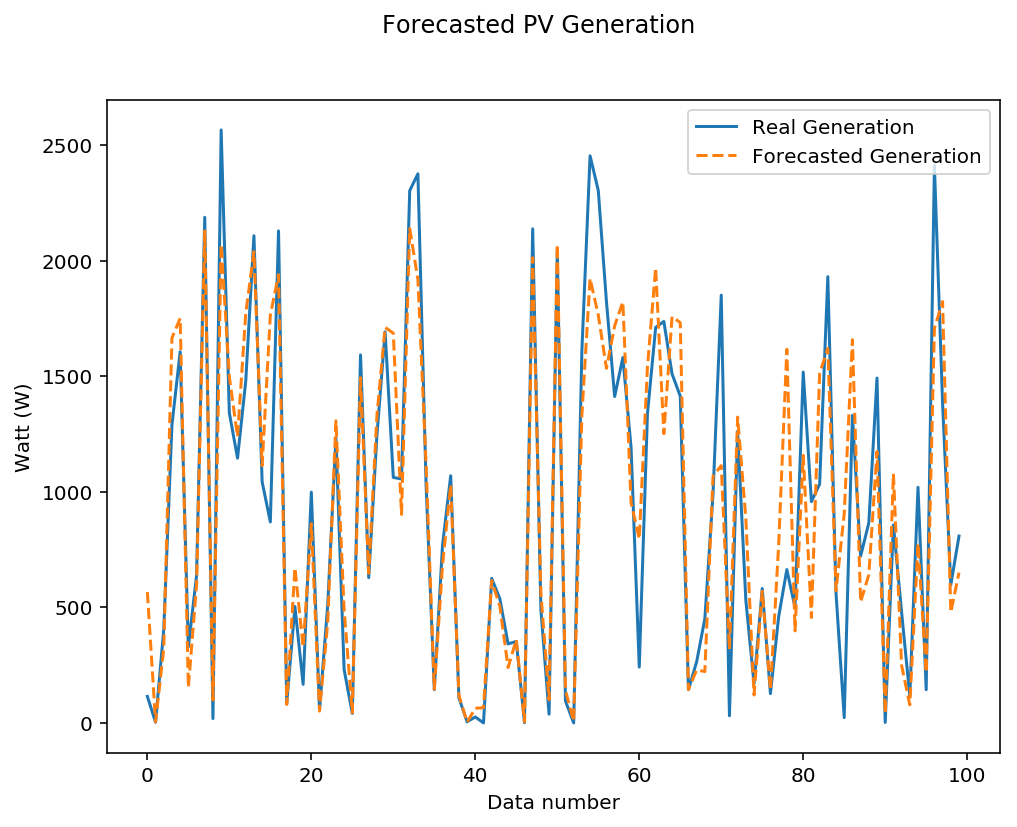

In [537]:
fig, ax = plt.subplots()

result['Real Generation'][0:100].plot(ax = ax, x_compat=True)
result['Forecasted Generation'][0:100].plot(ax = ax, x_compat=True, linestyle='--')
#Then tick and format with matplotlib:
#ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(h_fmt)
#fig.autofmt_xdate()
#plt.xticks(rotation='vertical', fontsize = 8)
plt.xlabel('Data number')
plt.ylabel('Watt (W)')
plt.suptitle('Forecasted PV Generation')
legend = ax.legend(loc='best')
plt.savefig('Train.png')
plt.show()

In [550]:
result["MAAPE"].mean()

32.75776623074684

In [14]:
dfNov= pd.read_csv("MAAPE_Nov.csv")

In [26]:
dfNov["Date"] = pd.to_datetime(dfNov["Date"])

In [32]:
dfNov.set_index(dfNov["Date"], inplace=True)

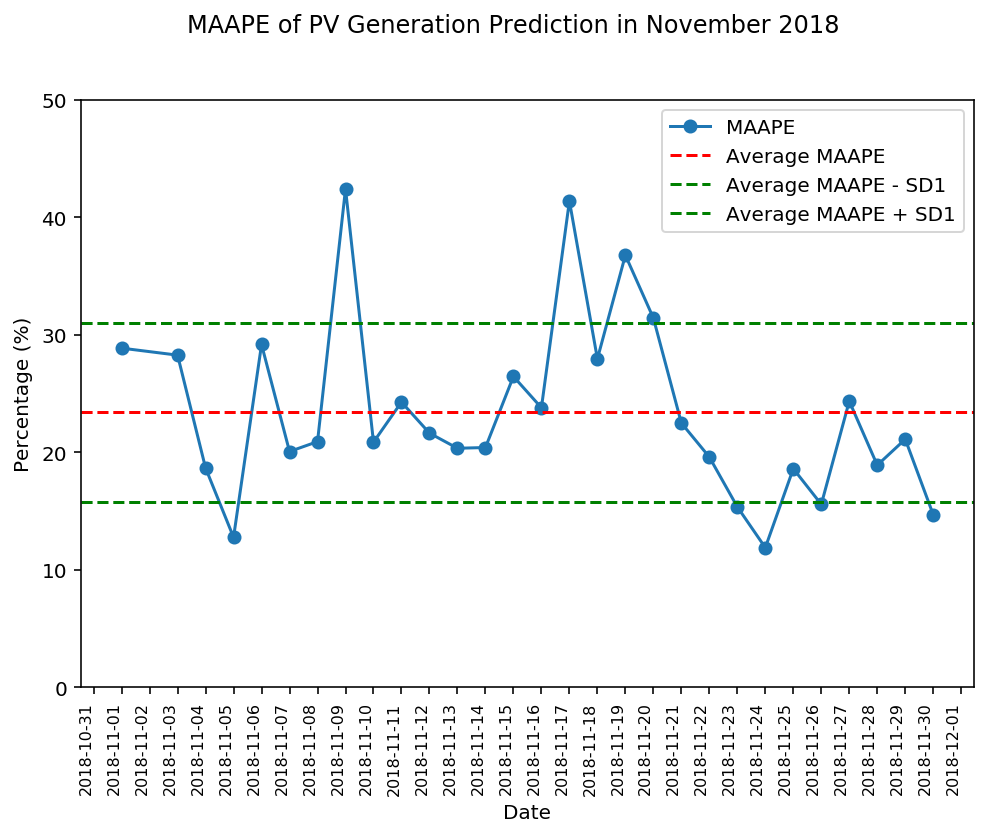

In [35]:
fig, ax = plt.subplots()

day = mdates.DayLocator(interval = 1)
myFmt = mdates.DateFormatter('%Y-%m-%d')

dfNov["MAAPE"].plot(ax = ax, x_compat=True ,marker='o')
#Then tick and format with matplotlib:
y_mean = dfNov["MAAPE"].mean()
y_sd = dfNov["MAAPE"].std()
plt.axhline(y=y_mean, label='Average MAAPE', linestyle='--', color='red')
plt.axhline(y=y_mean - y_sd, label='Average MAAPE - SD1', linestyle='--', color='green')
plt.axhline(y=y_mean + y_sd, label='Average MAAPE + SD1', linestyle='--', color='green')

ax.xaxis.set_major_locator(day)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.xticks(rotation='vertical', fontsize = 8)
ax.set_ylim(ymin=0, ymax=50)
legend = ax.legend(loc='best')
plt.ylabel('Percentage (%)')
plt.suptitle('MAAPE of PV Generation Prediction in November 2018')

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks()
ax2.set_yticklabels()

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.savefig('MAAPE_Nov.png')
#plt.show()